In [121]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Basic idea of derivatives

In [122]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

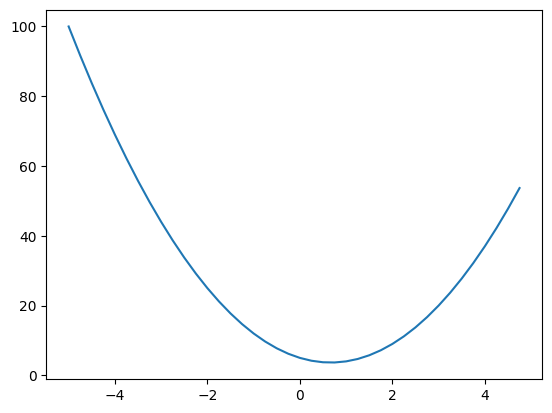

In [123]:
xs = np.arange (-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Derivative represent the direction and magnitude of a slight change in a function:

$L=\lim_{h\rightarrow 0} \frac{f(x+h)-f(x)}{h}$

In [124]:
h = 0.001
x = 3.0
effect = f(x + h) - f(x)
slope = effect/h #normalised by the value h
slope

14.00300000000243

The value $14.00300000000243$ is obtained by doing $\frac{\partial}{\partial x}(f(x))=6x-4$

In [125]:
h = 0.001
x = - 3.0
effect = f(x + h) - f(x)
slope = effect/h #normalised by the value h
slope

-21.996999999998934

In [126]:
h = 0.001
x = 2/3
effect = f(x + h) - f(x)
slope = effect/h #normalised by the value h
slope

0.0029999999995311555

### 1.2 Complex function cases

In [127]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [128]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

a += h

d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # the result is -3 which is equal to the derivative b = -3



d1 4.0
d2 3.999699999999999
slope -3.000000000010772


## 2. ```Value``` object

In [129]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ),'tanh')
        return out
    

    
a = Value(2.0, label='a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

In [130]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [131]:
d._op

'+'

In [132]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %4f}" % (n.label, n.data, n.grad),
            shape='record'
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

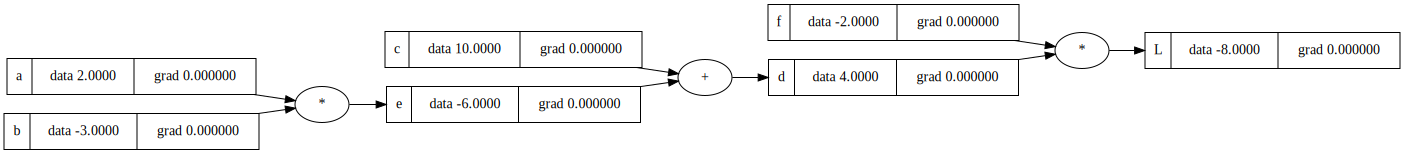

In [133]:
draw_dot(L)

In [134]:
def lol():
    '''
    Quick function to store Value as local and compute derivatives by tweaking 
    where the h is added.
    '''

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label='c')

    e = a*b; e.label = 'e'

    e.data += h
    d = e+c; d.label = 'd'



    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2 - L1)/h)


lol()



-2.000000000000668


**Manually computing gradient of L w.r.t different functions**

**1. dL/dL**

GIVEN:\
L = d*f

WANT:\
dL / dL = [(d*f + h) - d*f] / h = 1

**2. dL/dd**

GIVEN:\
L = d*f

WANT:\
dL / dd = [(d + h) * f - d * f] / h = f = -2.0

**3. dL/df**
GIVEN:\
L = d*f

WANT:\
dL / dd = [d * (f + h) - d * f] / h = d = 4.0

In [135]:
# Manually updating gradient values
L.grad = 1.0

f.grad = 4.0

d.grad = -2.0

### 2.1 Chain Rule

In **Leibniz's notation**, if a variable $z$ depends on the variable $y$, which itself depends on the variable $x$, then $z$ depends on $x$ as well, via the intermediate variable $y$. Hence:

$\frac{\partial z}{\partial x}=\frac{\partial z}{\partial y}\cdot \frac{\partial y}{\partial x}$

Intuitively, the chain rule states that knowing the instantaneous rate of change of z relative to y and that of y relative to x allows one to calculate the instantaneous rate of change of z relative to x as the product of the two rates of change.

As put by George F. Simmons: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

**4. dL/dc**

GIVEN:\
d = e+c\
f = Value(-2.0, label='f')\
L = d*f

WANT:\
dL / dc = (dL / dd) * (dd / dc) = -2.0

KNOW:\
dL / dd = f = -2.0\
dd / dc = 1

In [136]:
c.grad = -2.0
e.grad = -2.0

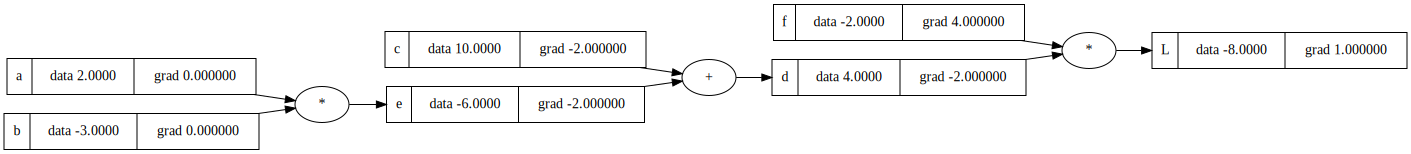

In [137]:
draw_dot(L)

**5. dL / da**

GIVEN:\
e = a * b

WANT:\
dL / de = -2.0 \
de / da = b

dL / da = (dL / de) * (de / da) = -2.0 * b = -2.0 * (-3.0) = 6

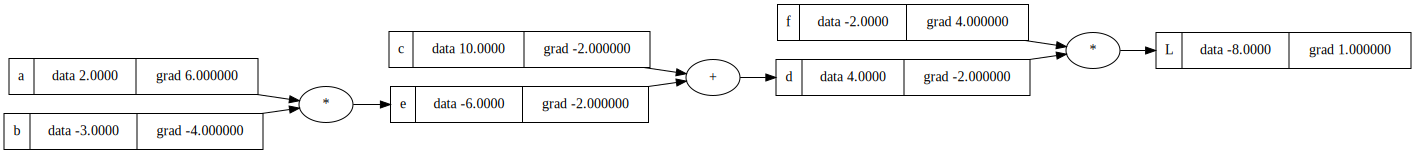

In [138]:
a.grad = 6.0
b.grad = -4.0

draw_dot(L)

Now we test that the cumulative final gradient of L = 1.0 is actually correct,  by slightly increasing all values. We expect F to slight increase as the slope is positive

In [139]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-7.4352)

## 3. Manual backpropagation with a mathematical neuron

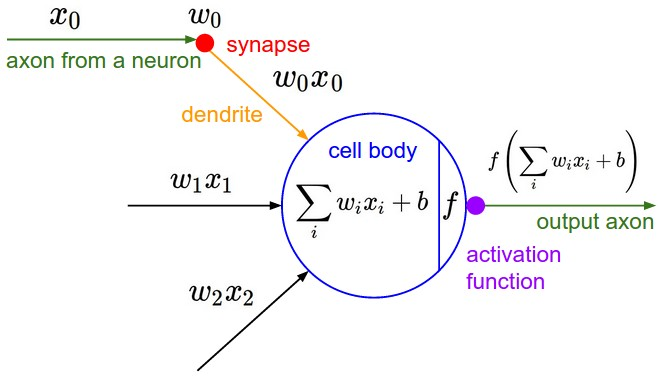

In this graph we can see that:
- $x_i$ represents a raw input = a **neuron**
- At each synapses lies a $w_i$, which represents a weight. The synapse interacts multiplicative with the neurons and send the results to the **cell body** as a **dendrite**
- The cell body has a **bias** $b$, which triggers the function more/less regardless of the inputs
- The cell body gets taken through an activation function, usually a squashing function and returns an output

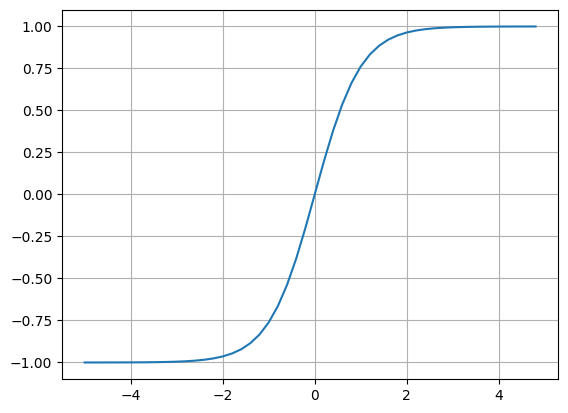

In [140]:
# Example with hyperbolic tangent

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

$\tanh x=\frac{\sinh x}{\cosh x}= \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}=\frac{e^{2x}+1}{e^{2x}-1}$

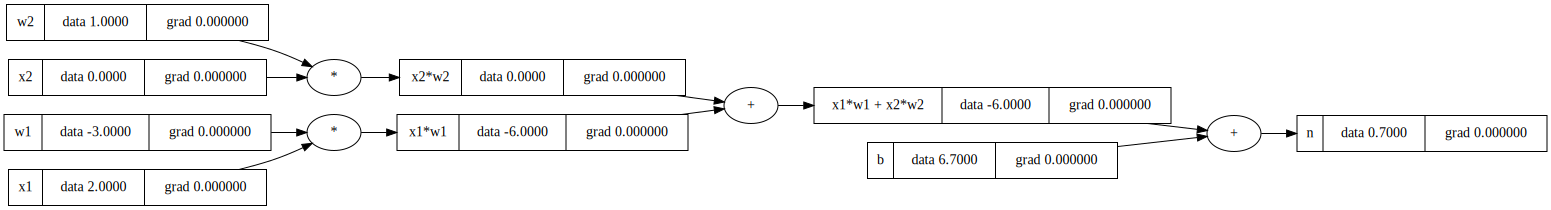

In [141]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.7, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# cell body (without activation)
n = x1w1x2w2 + b; n.label = 'n'

draw_dot(n)


To represent $\tanh x=\frac{\sinh x}{\cosh x}= \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}=\frac{e^{2x}+1}{e^{2x}-1}$ using our ```Value``` object we need to implement an exponentiation operation. But in reality we do not need to implement each atomic operation in the ```Value``` object, we can create function at a certain level of abstraction, as long as we know how to obtain the local derivative. In this case we create the ```tanh(self)``` method within the ```Value``` object, which takes the data as input and outputs $\tanh x = \frac{e^{2x}+1}{e^{2x}-1}$ as output, utilising the ```math``` py library.

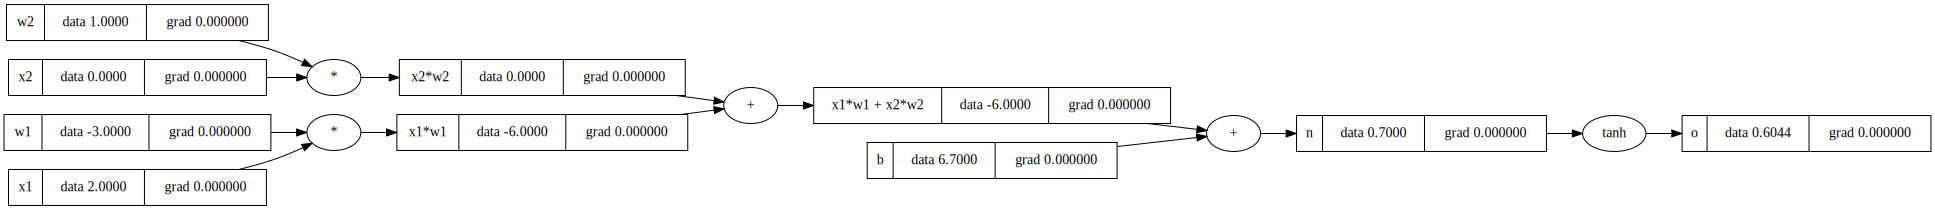

In [142]:
# output

o = n.tanh(); o.label = 'o'
draw_dot(o)

By iteratevily changing the bias b, we can see how the more the n increases the more $\tanh$ sqashes the calues, as shown in the graph

In [143]:
b = Value(6.7, label='b')

for i in range(7, 15):
    b = Value(i, label='b')
    # x1w1 + x2w2 + b
    x1w1 = x1*w1; x1w1.label = 'x1*w1'
    x2w2 = x2*w2; x2w2.label = 'x2*w2'

    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

    # cell body (without activation)
    n = x1w1x2w2 + b; n.label = 'n'
    o = n.tanh()
    print(o)
    

Value(data=0.7615941559557649)
Value(data=0.9640275800758169)
Value(data=0.9950547536867305)
Value(data=0.999329299739067)
Value(data=0.9999092042625951)
Value(data=0.9999877116507956)
Value(data=0.9999983369439447)
Value(data=0.9999997749296758)


In [144]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# cell body (without activation)
n = x1w1x2w2 + b; n.label = 'n'

# output

o = n.tanh(); o.label = 'o'

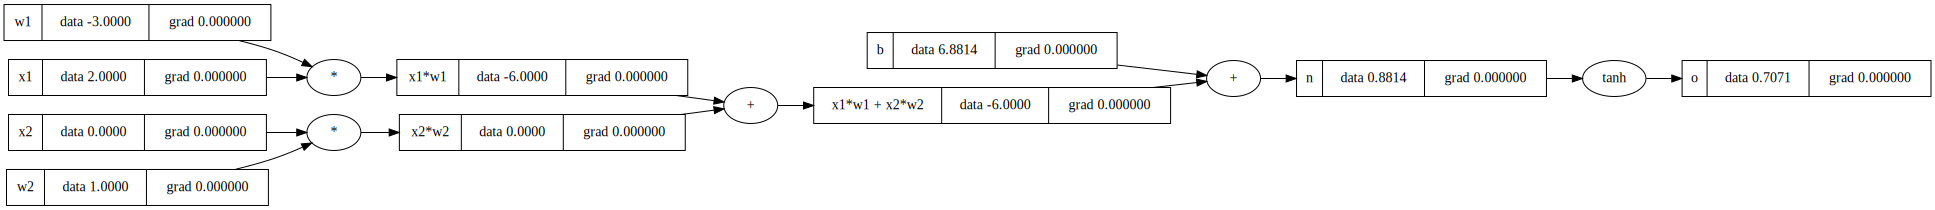

In [145]:
draw_dot(o)

We start by manually backpropagating the $\tanh$ function

In [146]:
o.grad = 1.0

# o = tanh(n)
# do / dn = 1 - o**2

n.grad = 1 - o.data**2

b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad


x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

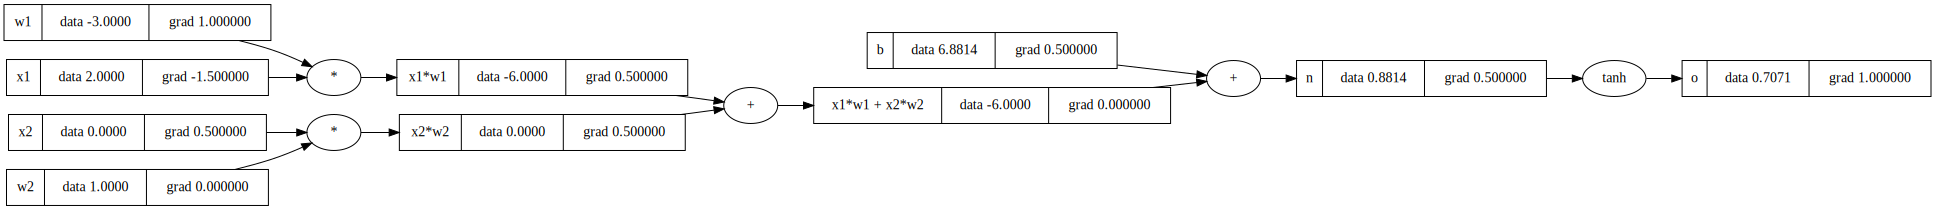

In [147]:
draw_dot(o)

## 4. Automatic Backpropagation

Now that we have a clear understanding of what it means to manually backpropagate we can codify the steps into our ```Value``` object.


In [152]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = (other.data * out.grad)
            other.grad = (self.data *out.grad)

        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ),'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out

In [166]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# cell body (without activation)
n = x1w1x2w2 + b; n.label = 'n'

# output

o = n.tanh(); o.label = 'o'

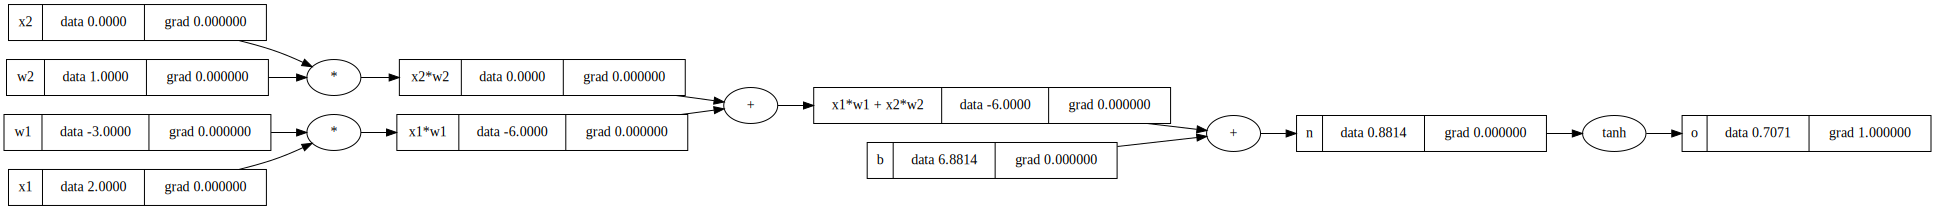

In [154]:
o.grad = 1.0
draw_dot(o)

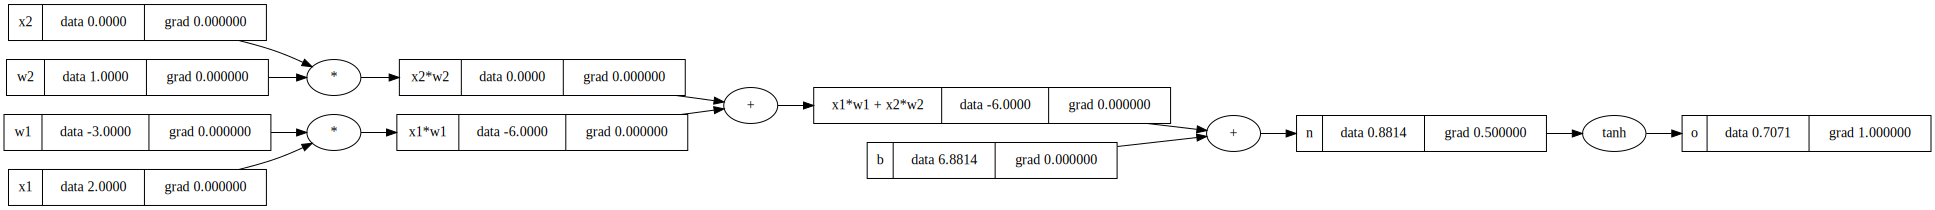

In [156]:
o._backward()
draw_dot(o)

We can see the function has backpropagated and computed n.grad = 0.5

In [157]:
n._backward()

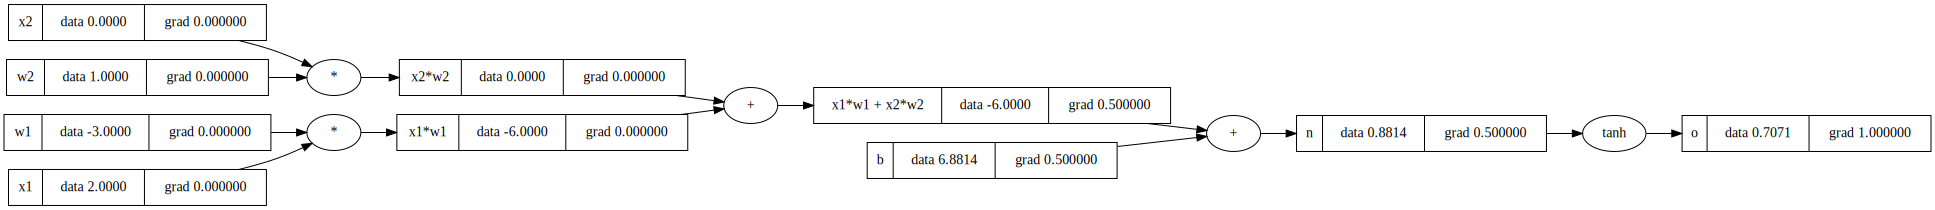

In [158]:
draw_dot(o)

In [159]:
b._backward() # nothing happens as b is not a function but a value

In [160]:
x1w1x2w2._backward()

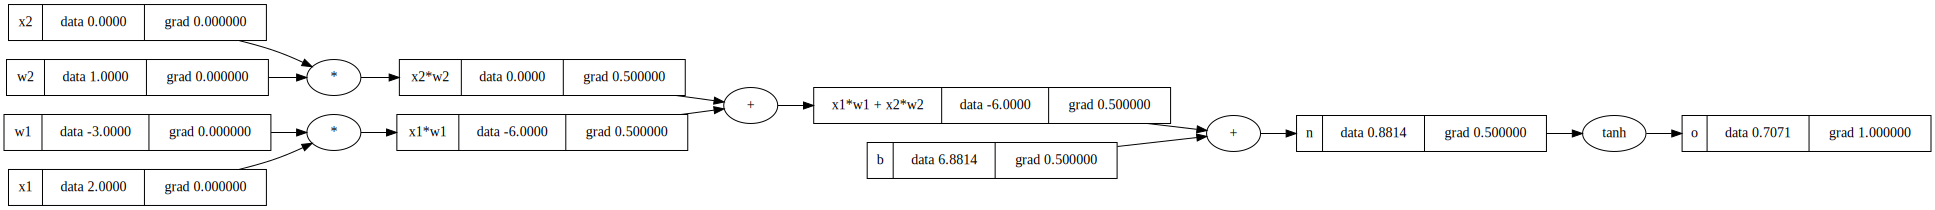

In [161]:
draw_dot(o)

In [162]:
x1w1._backward()
x2w2._backward()

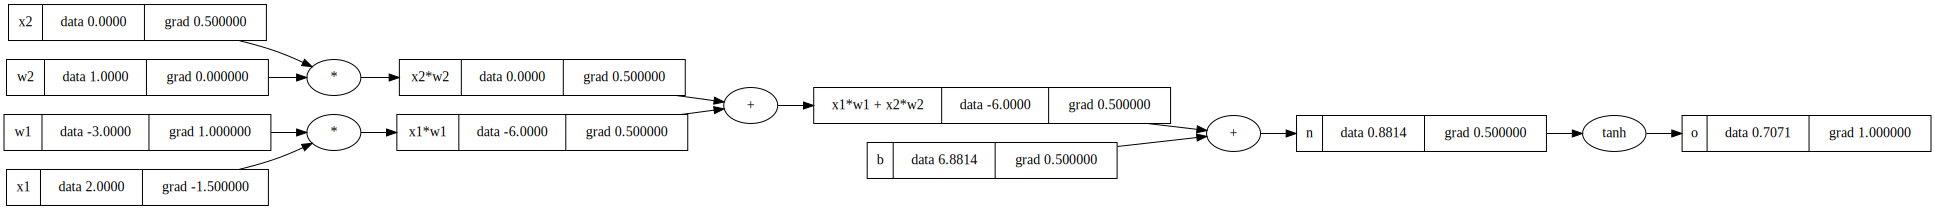

In [163]:
draw_dot(o)

The final step is to automate even the calling of the ```._backward()``` function on all the components.

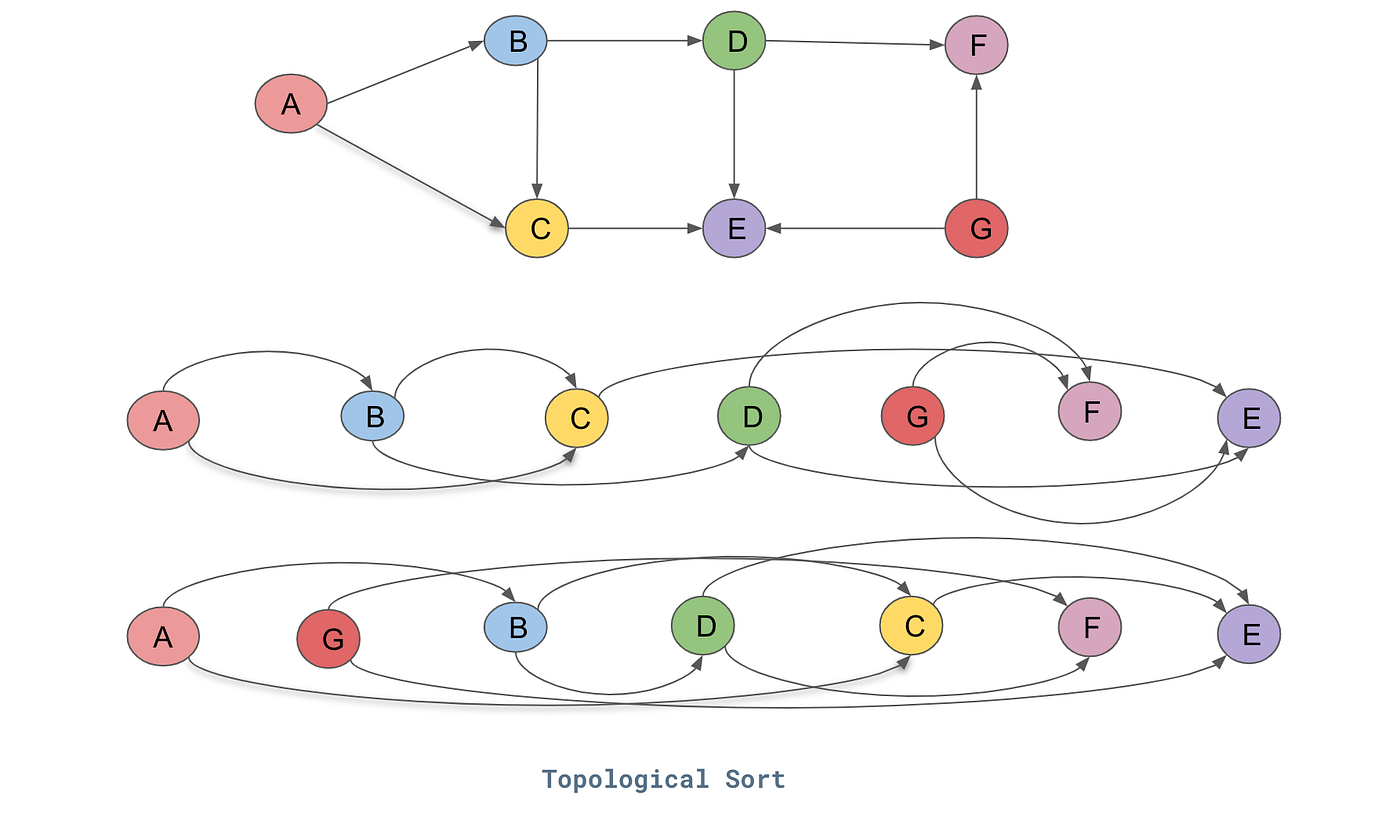

We can do so by using a **topological sort**

In [165]:
topo = []

visited = set()

def build_topo(v):
    '''
    Ensures, starting from a node, that the note will add itself to the list 
    only after all of its child are added
    '''
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

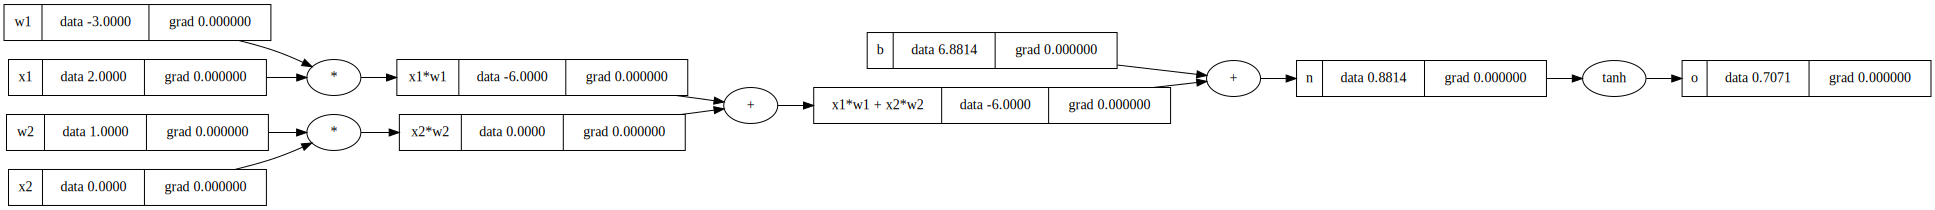

In [ ]:
# reset the gradient 
draw_dot(o)

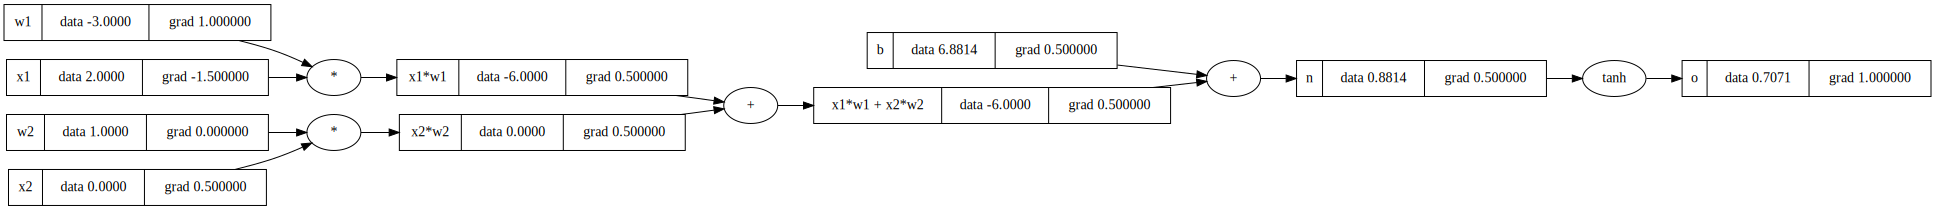

In [169]:
o.grad = 1.0

topo = []
visited = set()

def build_topo(v):
    '''
    Ensures, starting from a node, that the note will add itself to the list 
    only after all of its child are added
    '''
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

for node in reversed(topo):
    node._backward()

draw_dot(o)

Now we need to implment the topological sorting in the ```Value``` object.

In [170]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = (other.data * out.grad)
            other.grad = (self.data *out.grad)

        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ),'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [171]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# cell body (without activation)
n = x1w1x2w2 + b; n.label = 'n'

# output

o = n.tanh(); o.label = 'o'

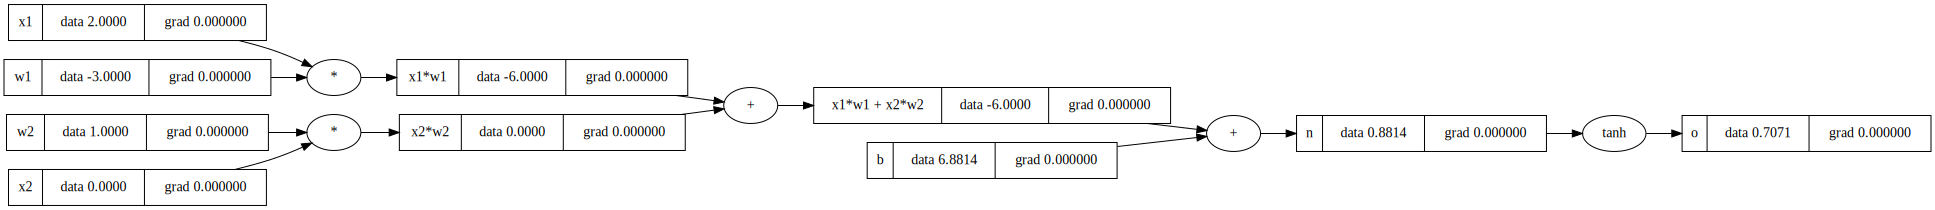

In [172]:
draw_dot(o)

In [173]:
o.backward()

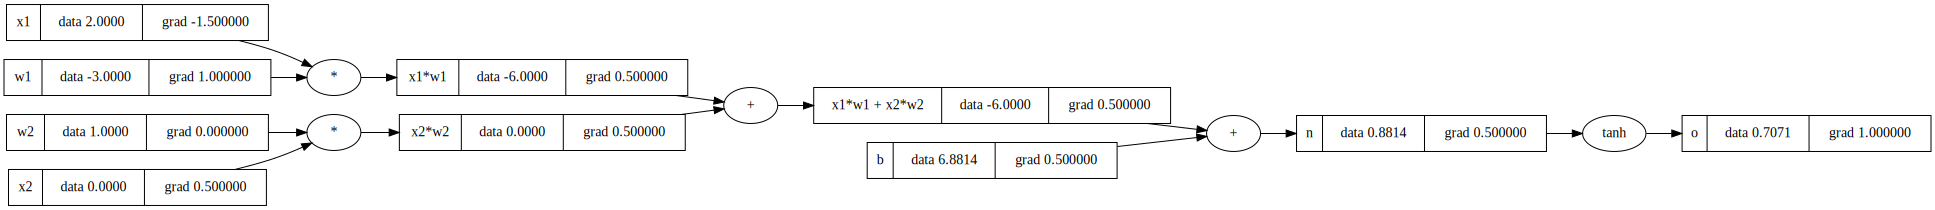

In [174]:
draw_dot(o)

This method however hides a bug. Consider:

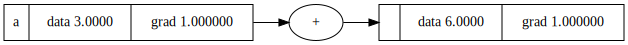

In [175]:
a = Value(3.0, label = 'a')
b = a + a
b.backward()
draw_dot(b)

In this case:
- The forward addition of $a + a = 3 + 3 = 6$ works
- but, the backpropagation fails

$\frac{\partial b}{\partial a}= 1 + 1 = 2$

But we get $1$. Why?

- When running ```b = a + a``` we call the ```_add(self, other)``` method, in which ```out``` is b
- But, a is both ```self``` and ```other```, hence when running ```_backward()``` we are simply overriding ```self.grad``` and ```other.grad``` instead of properly adding them 


This issue occurs in general when a variable is used **more than once**.

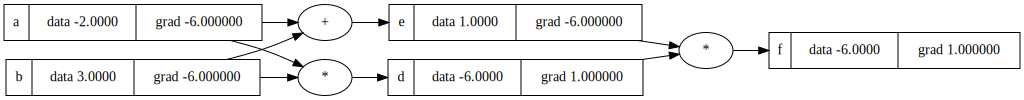

In [176]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()
draw_dot(f)

Even in this case the gradients are properly set when f's child e is processed, but then overwritten when d is processed.

The solution, instead of overriding the gradient is to accumulate them.

In [177]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad # Cumulates gradient
            other.grad += 1.0 * out.grad # Cumulates gradient

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += (other.data * out.grad) # Cumulates gradient
            other.grad += (self.data *out.grad) # Cumulates gradient

        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ),'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad # Cumulates gradient

        out._backward = _backward
        return out
    
    def backward(self):
        
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

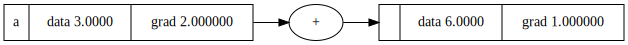

In [178]:
a = Value(3.0, label = 'a')
b = a + a
b.backward()
draw_dot(b)

## 5. Improvements on the Value object

In [1]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        '''
        Addition operation, ensuring integer addition
        '''
        other = other if isinstance(other, Value) else Value(other)
        # Ensures even an integer can be added 
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad 

        out._backward = _backward
        return out

    def __mul__(self, other):
        '''
        Multiplication operation, ensuring integer mult
        '''
        other = other if isinstance(other, Value) else Value(other)
        # Ensures even an integer can be multiplied
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += (other.data * out.grad) 
            other.grad += (self.data *out.grad) 

        out._backward = _backward
        return out
    
    def __pow__(self, other):
        '''
        Power
        '''
        assert isinstance(other, (int, float)), "only supporting int/float pow"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        '''
        Reversed Multiplication
        '''
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        '''
        Hyperbolic function
        '''
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ),'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad 

        out._backward = _backward
        return out

    def exp(self):
        '''
        Exponentiation operation
        '''
        x = self.data
        out = Value(math.exp(x), (self, ),'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        '''
        Backpropagation
        '''
        
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()